전체 데이터 크기: (192544, 15)
원본 rating 고유값: [10.  8.  4.  6.  2. nan]
학습+테스트 데이터 크기: (173289, 9), 새로운 데이터 크기: (19255, 9)
학습 데이터 크기: (121302, 9), 테스트 데이터 크기: (51987, 9)
학습 데이터 rating_5 고유값: [4 3 5 2 1]
테스트 데이터 rating_5 고유값: [5 4 3 2 1]
height_cm 열을 평균값 165.91로 채웠습니다.
weight_kg 열을 평균값 62.36로 채웠습니다.
rating_5 열을 평균값 4.55로 채웠습니다.
age 열을 평균값 33.87로 채웠습니다.
size 열을 평균값 12.28로 채웠습니다.
fit 열을 최빈값 fit로 채웠습니다.
body type 열을 최빈값 hourglass로 채웠습니다.

학습 데이터 결측치:
user_id          0
item_id          0
fit              0
weight       18846
rating           0
body type        0
height         441
size             0
age              0
height_cm        0
weight_kg        0
rating_5         0
dtype: int64

테스트 데이터 결측치:
user_id         0
item_id         0
fit             0
weight       8088
rating          0
body type       0
height        176
size            0
age             0
height_cm       0
weight_kg       0
rating_5        0
dtype: int64

학습용 피처 컬럼: ['weight_kg_scaled', 'height_cm_scaled', 'size_scaled', 'age

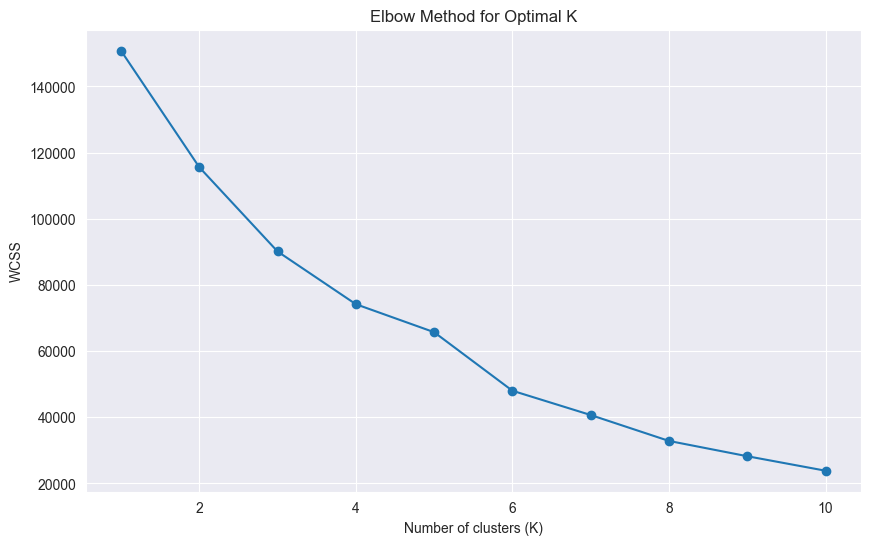


학습 데이터 군집별 실제 값 평균:
         weight_kg   height_cm       size        age  rating_5
cluster                                                       
0        57.409478  169.716893   7.133470  33.345931  4.686478
1        64.339008  166.338894  13.967421  33.924572  4.654887
2        61.689631  167.640634  10.503306  33.748068  4.664965
3        65.044388  166.716750  14.003239  33.758680  4.627466
4        66.351355  165.487680  17.872450  35.056609  4.622193
5        53.602697  158.430271   5.344324  33.186599  4.663651
6        64.410780  166.444502  15.964915  33.952157  4.205808
7        62.172870  167.594202  12.989853  33.713511  4.248331
8        63.925451  166.061400  12.525080  33.501062  4.317858
9        69.682695  165.276905  21.084436  36.683927  4.571429
10       65.086193  166.444774  12.575895  33.632294  4.314170
11       67.034315  165.748431  19.917726  35.495959  4.088257
12       61.491806  167.528820   9.166617  33.547303  4.290303
13       54.076788  158.439058   7

C:\Users\user\AppData\Local\Temp\ipykernel_1840\1670739569.py:189: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_items = train_df.groupby('cluster').apply(


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import os

#전체 데이터 : 20만
#학습+테스트 : 18만
#새로운 데이터 : 2만
#클러스터링 특성(6가지): weight_kg, height_cm, size, age, fit, body type
#추천.평가: rating_5
#데이터 실루엣 점수: 0.831

# 출력 디렉토리 생성
os.makedirs('plots', exist_ok=True)

# 데이터 로드
df = pd.read_csv('../renttherunway_data.csv')
print(f"전체 데이터 크기: {df.shape}")

# 원본 rating 분포 확인
print("원본 rating 고유값:", df['rating'].unique())

# 선택한 컬럼
selected_columns = ['user_id', 'item_id', 'fit', 'weight', 'rating', 'body type', 'height', 'size', 'age']
df = df[selected_columns]

# 데이터 분할: 학습+테스트(90%, 18만)와 새로운 데이터(10%, 2만)
df_train_test, new_df = train_test_split(df, test_size=0.1, random_state=42)
print(f"학습+테스트 데이터 크기: {df_train_test.shape}, 새로운 데이터 크기: {new_df.shape}")

# 학습/테스트 분할: 학습(70% of 90% ≈ 12.6만), 테스트(30% of 90% ≈ 5.4만)
train_df, test_df = train_test_split(df_train_test, test_size=0.3, random_state=42)
print(f"학습 데이터 크기: {train_df.shape}, 테스트 데이터 크기: {test_df.shape}")

# 새로운 데이터가 비어있는지 확인
if new_df.empty:
    print("오류: 새로운 데이터가 비어 있습니다. 데이터 분할을 확인하세요.")
    exit(1)

# 1. 단위 변환 및 전처리
def height_to_cm(height):
    if pd.isna(height):
        return np.nan
    try:
        feet, inches = height.split("'")
        inches = inches.replace('"', '').strip()
        return int(feet) * 30.48 + int(inches) * 2.54
    except:
        return np.nan

# 학습 데이터 전처리
train_df['height_cm'] = train_df['height'].apply(height_to_cm)
train_df['weight'] = train_df['weight'].astype(str).str.replace('lbs', '').str.strip()
train_df['weight'] = pd.to_numeric(train_df['weight'], errors='coerce')
train_df['weight_kg'] = train_df['weight'] * 0.453592

train_df['rating'] = pd.to_numeric(train_df['rating'], errors='coerce')
train_df['rating'] = train_df['rating'].replace([np.inf, -np.inf], np.nan)
rating_median = train_df['rating'].median()
train_df['rating'] = train_df['rating'].fillna(rating_median)
train_df['rating_5'] = (train_df['rating'] / 2).round().astype(int)
train_df['rating_5'] = train_df['rating_5'].clip(1, 5)

# 테스트 데이터 전처리
test_df['height_cm'] = test_df['height'].apply(height_to_cm)
test_df['weight'] = test_df['weight'].astype(str).str.replace('lbs', '').str.strip()
test_df['weight'] = pd.to_numeric(test_df['weight'], errors='coerce')
test_df['weight_kg'] = test_df['weight'] * 0.453592

test_df['rating'] = pd.to_numeric(test_df['rating'], errors='coerce')
test_df['rating'] = test_df['rating'].replace([np.inf, -np.inf], np.nan)
test_df['rating'] = test_df['rating'].fillna(rating_median)
test_df['rating_5'] = (test_df['rating'] / 2).round().astype(int)
test_df['rating_5'] = test_df['rating_5'].clip(1, 5)

# rating_5 확인
print("학습 데이터 rating_5 고유값:", train_df['rating_5'].unique())
print("테스트 데이터 rating_5 고유값:", test_df['rating_5'].unique())

# 2. 결측치 처리
numeric_columns = ['height_cm', 'weight_kg', 'rating_5', 'age', 'size']
for col in numeric_columns:
    mean_value = train_df[col].mean()
    train_df[col] = train_df[col].replace([np.inf, -np.inf], np.nan)
    train_df[col] = train_df[col].fillna(mean_value)
    test_df[col] = test_df[col].replace([np.inf, -np.inf], np.nan)
    test_df[col] = test_df[col].fillna(mean_value)
    print(f"{col} 열을 평균값 {mean_value:.2f}로 채웠습니다.")

categorical_columns = ['fit', 'body type']
for col in categorical_columns:
    mode_value = train_df[col].mode()[0]
    train_df[col] = train_df[col].fillna(mode_value)
    test_df[col] = test_df[col].fillna(mode_value)
    print(f"{col} 열을 최빈값 {mode_value}로 채웠습니다.")

print("\n학습 데이터 결측치:")
print(train_df.isna().sum())
print("\n테스트 데이터 결측치:")
print(test_df.isna().sum())

# 3. 원-핫 인코딩
encoder_fit = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
fit_encoded_train = encoder_fit.fit_transform(train_df[['fit']])
fit_encoded_train_df = pd.DataFrame(fit_encoded_train, columns=encoder_fit.get_feature_names_out(['fit']), index=train_df.index)
fit_encoded_test = encoder_fit.transform(test_df[['fit']])
fit_encoded_test_df = pd.DataFrame(fit_encoded_test, columns=encoder_fit.get_feature_names_out(['fit']), index=test_df.index)

encoder_body = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
body_encoded_train = encoder_body.fit_transform(train_df[['body type']])
body_encoded_train_df = pd.DataFrame(body_encoded_train, columns=encoder_body.get_feature_names_out(['body type']), index=train_df.index)
body_encoded_test = encoder_body.transform(test_df[['body type']])
body_encoded_test_df = pd.DataFrame(body_encoded_test, columns=encoder_body.get_feature_names_out(['body type']), index=test_df.index)

train_df = pd.concat([train_df, fit_encoded_train_df, body_encoded_train_df], axis=1)
test_df = pd.concat([test_df, fit_encoded_test_df, body_encoded_test_df], axis=1)

# 4. 스케일링
scaler_dict = {}
scaled_columns = ['weight_kg', 'height_cm', 'size', 'age']  # rating_5 제외
all_columns = ['weight_kg', 'height_cm', 'size', 'age'] + \
              [col for col in train_df.columns if col.startswith(('fit_', 'body type_'))]

# for col in scaled_columns:
#     scaler = MinMaxScaler()
#     train_df[f'{col}_scaled'] = scaler.fit_transform(train_df[[col]])
#     test_df[f'{col}_scaled'] = scaler.transform(test_df[[col]])
#     scaler_dict[col] = scaler

# feature_columns = [f'{col}_scaled' for col in scaled_columns] + \
#                   [col for col in train_df.columns if col.startswith(('fit_', 'body type_'))]
#                 # [col for col in train_df.columns if col.startswith(('fit_'))]
for col in all_columns:
    scaler = MinMaxScaler()
    train_df[f'{col}_scaled'] = scaler.fit_transform(train_df[[col]])
    test_df[f'{col}_scaled'] = scaler.transform(test_df[[col]])
    scaler_dict[col] = scaler

feature_columns = [f'{col}_scaled' for col in all_columns]

train_features_df = train_df[feature_columns]
test_features_df = test_df[feature_columns]

print("\n학습용 피처 컬럼:", feature_columns)

# 5. K-Means 클러스터링
# 엘보우 기법
wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(train_features_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.savefig('plots/elbow_plot.png')
plt.show()
plt.close()

# K=20으로 설정
optimal_k = 20
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
train_df['cluster'] = kmeans.fit_predict(train_features_df)
test_df['cluster'] = kmeans.predict(test_features_df)

# 실루엣 점수 계산 (학습, 테스트)
train_silhouette = silhouette_score(train_features_df, train_df['cluster'])
test_silhouette = silhouette_score(test_features_df, test_df['cluster'])

# 6. 군집별 특성 분석
original_columns = ['weight_kg', 'height_cm', 'size', 'age', 'rating_5']
train_cluster_summary = train_df.groupby('cluster')[original_columns].mean()
test_cluster_summary = test_df.groupby('cluster')[original_columns].mean()
print("\n학습 데이터 군집별 실제 값 평균:")
print(train_cluster_summary)
print("\n테스트 데이터 군집별 실제 값 평균:")
print(test_cluster_summary)

# 7. 상품 추천
cluster_items = train_df.groupby('cluster').apply(
    lambda x: x.nlargest(5, 'rating_5')[['item_id', 'rating_5']].to_dict('records')
)
print("\n군집별 상위 5개 추천 상품 (item_id, rating_5):")
for cluster, items in cluster_items.items():
    print(f"Cluster {cluster}:")
    for item in items:
        print(f"  Item ID: {item['item_id']}, Rating: {item['rating_5']}")

# 8. 추천 평가
# 학습 데이터 평가
precision_scores_train = []
recall_scores_train = []
K = 5
for cluster in train_df['cluster'].unique():
    train_items = set(train_df[(train_df['cluster'] == cluster) & (train_df['rating_5'] >= 4)]['item_id'])
    recommended_items = set(item['item_id'] for item in cluster_items.get(cluster, []))
    hits = len(train_items & recommended_items)
    precision = hits / K if K > 0 else 0
    recall = hits / len(train_items) if train_items else 0
    precision_scores_train.append(precision)
    recall_scores_train.append(recall)
f1_scores_train = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_scores_train, recall_scores_train)]

# 테스트 데이터 평가
precision_scores = []
recall_scores = []
for cluster in test_df['cluster'].unique():
    test_items = set(test_df[(test_df['cluster'] == cluster) & (test_df['rating_5'] >= 4)]['item_id'])
    recommended_items = set(item['item_id'] for item in cluster_items.get(cluster, []))
    hits = len(test_items & recommended_items)
    precision = hits / K if K > 0 else 0
    recall = hits / len(test_items) if test_items else 0
    precision_scores.append(precision)
    recall_scores.append(recall)
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision_scores, recall_scores)]

# 고유 추천 상품 수
unique_items = set()
for cluster, items in cluster_items.items():
    unique_items.update(item['item_id'] for item in items)

# 테스트 데이터 높은 평점 비율
feedback_scores = []
for cluster in test_df['cluster'].unique():
    recommended_items = set(item['item_id'] for item in cluster_items.get(cluster, []))
    cluster_data = test_df[(test_df['cluster'] == cluster) & (test_df['item_id'].isin(recommended_items))]
    if not cluster_data.empty:
        feedback_score = (cluster_data['rating_5'] >= 4).mean()
        feedback_scores.append(feedback_score)
    else:
        feedback_scores.append(0)

# 출력 (요청된 순서)
print(f"\n학습 데이터 평균 Precision@{K}: {np.mean(precision_scores_train):.3f}")
print(f"학습 데이터 평균 Recall@{K}: {np.mean(recall_scores_train):.3f}")
print(f"학습 데이터 평균 F1 Score: {np.mean(f1_scores_train):.3f}")
print(f"테스트 데이터 평균 Precision@{K}: {np.mean(precision_scores):.3f}")
print(f"테스트 데이터 평균 Recall@{K}: {np.mean(recall_scores):.3f}")
print(f"테스트 데이터 평균 F1 Score: {np.mean(f1_scores):.3f}")
print(f"학습 데이터 실루엣 점수: {train_silhouette:.3f}")
print(f"테스트 데이터 실루엣 점수: {test_silhouette:.3f}")
print(f"총 고유 추천 상품 수: {len(unique_items)}")
print(f"테스트 데이터 추천 상품의 높은 평점 비율 (평균): {np.mean(feedback_scores):.3f}")

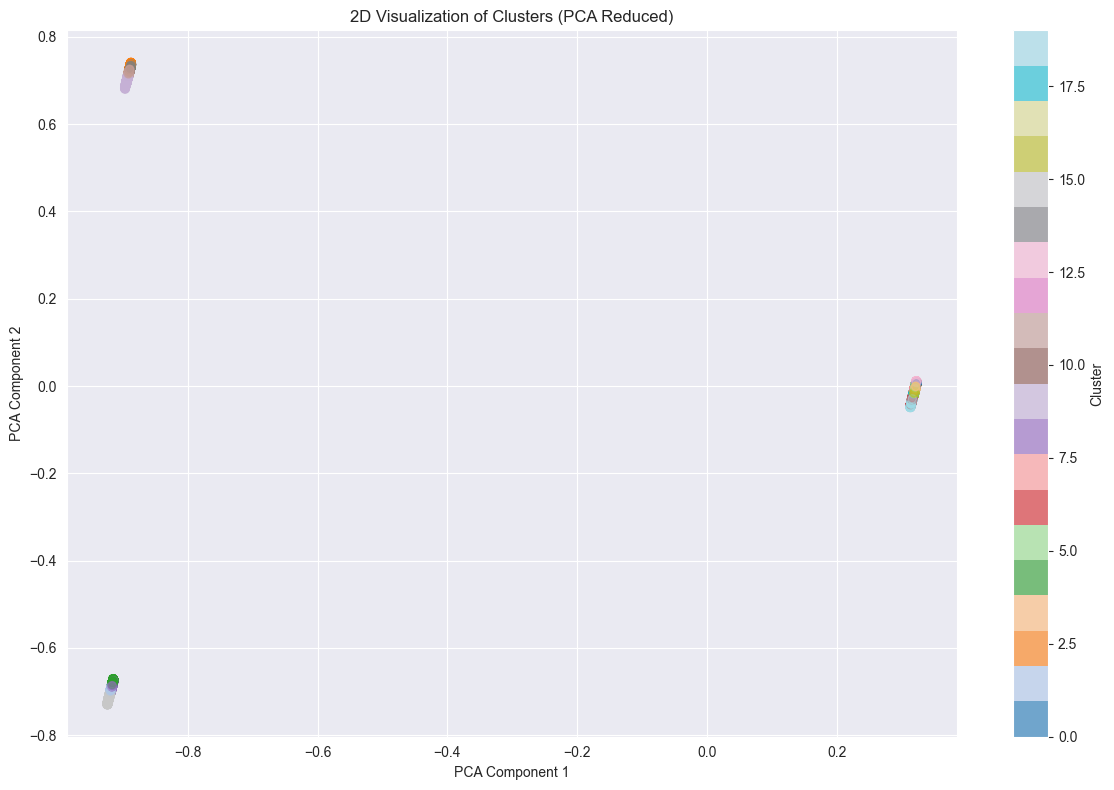

In [20]:
from sklearn.decomposition import PCA

# PCA로 2차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train_features_df)

# 시각화
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_df['cluster'], cmap='tab20', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('2D Visualization of Clusters (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

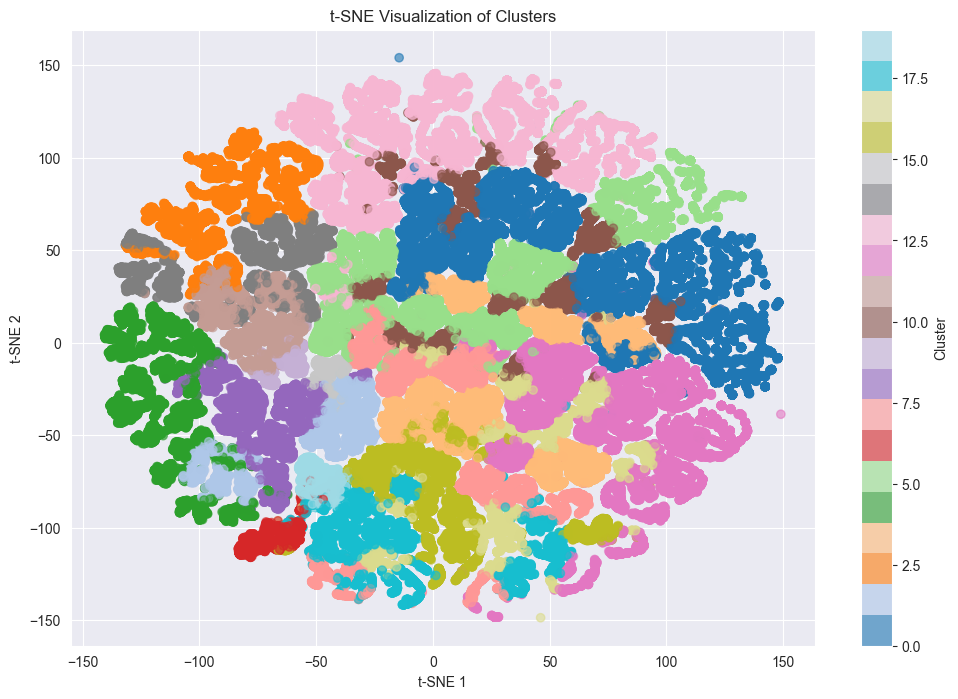

In [21]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(train_features_df)

plt.figure(figsize=(12, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=train_df['cluster'], cmap='tab20', alpha=0.6)
plt.colorbar(label='Cluster')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)
plt.show()


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\l

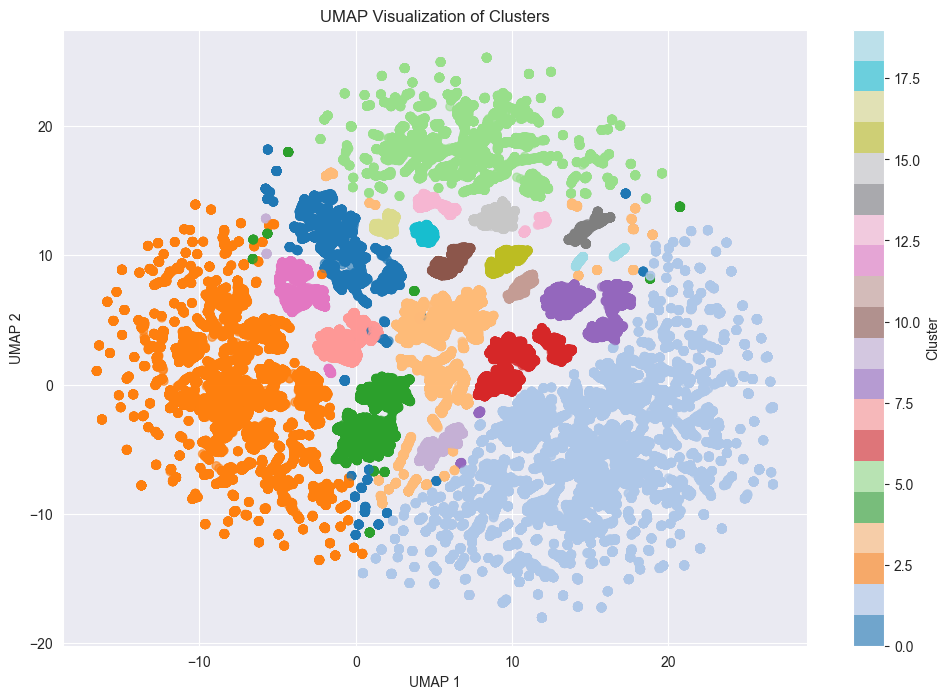

In [18]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(train_features_df)

plt.figure(figsize=(12, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=train_df['cluster'], cmap='tab20', alpha=0.6)
plt.colorbar(label='Cluster')
plt.title('UMAP Visualization of Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()